In [1]:
import os
import sys
import json
import time
import warnings

warnings.filterwarnings('ignore')
sys.path.append(os.path.expanduser('~/conekta/fraud_prevention/'))

import pandas as pd

from fraud_prevention.features import dataset
from fraud_prevention.models import model_experiment
from fraud_prevention.evaluation import threshold_table as threshold_table_module

from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [28]:
(
    X_train, X_test, X_val,
    y_train, y_test, y_val,
    w_train, w_test, w_val
) = dataset.get(
    test_size=0.5, 

    val_size=.3,
    use_smote=True
)

pd.DataFrame([
    {
        "name": "train", 
        "size": X_train.shape[0], 
        "pos_class": (y_train == 1).sum(), 
        "new_class": (y_train == 0).sum()
    },
    {
        "name": "val", 
        "size": X_val.shape[0], 
        "pos_class": (y_val == 1).sum(), 
        "new_class": (y_val == 0).sum()
    },
    {
        "name": "test", 
        "size": X_test.shape[0], 
        "pos_class": (y_test == 1).sum(), 
        "new_class": (y_test == 0).sum()
    }, 
]).set_index('name')

,size,pos_class,new_class
name,,,
train,140117,69924,70193
val,60051,30160,29891
test,142404,246,142158


In [ ]:
# Scorer definitions
f1_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Train models with cross-validation and hyperparameter tuning
results = {}
for model_name, pipeline in pipelines.items():
    start = time.time()
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        scoring={'F1': f1_scorer, 'ROC_AUC': roc_auc_scorer},
        refit='ROC_AUC',
        cv=3,
        n_jobs=-1
    )
    
    if model_name in ['xgboost', 'lightgbm']:
        grid_search.fit(
            X_train,
            y_train,
            model__verbose=False,
            model__sample_weight=w_train,
            model__eval_set=[(X_train, y_train), (X_val, y_val)],
            model__early_stopping_rounds=10)
    else:
        grid_search.fit(
            X_train,
            y_train)
        
    end = time.time()

    grid_search_elapsed_time = round((end - start) / 60, 2)
    
    # Best model and performance
    best_model = grid_search.best_estimator_
    f1 = cross_val_score(
        best_model,
        X_test,
        y_test,
        scoring=f1_scorer,
        cv=5
    ).mean()
    roc_auc = cross_val_score(
        best_model,
        X_test,
        y_test,
        scoring=roc_auc_scorer,
        cv=5
    ).mean()

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'elapsed_time': grid_search_elapsed_time,
        'best_model': best_model
    }

Training lightgbm...


In [ ]:
# Display results
for model, metrics in results.items():
    print(f"Model: {model} ({metrics['elapsed_time']}min)")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

<Axes: title={'center': 'Binary Logloss'}>

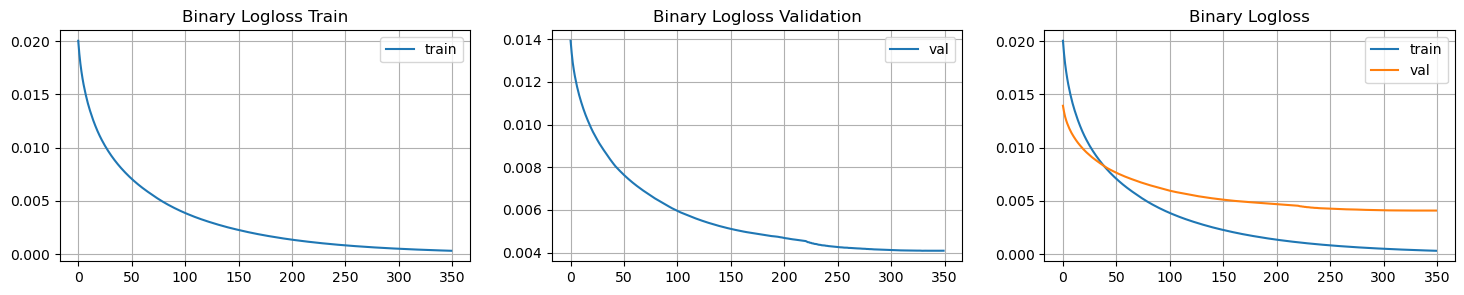

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 3))

logloss_logs = pd.DataFrame({
    "train": metrics['best_model'].steps[0][-1].evals_result_['training']['binary_logloss'],
    "val": metrics['best_model'].steps[0][-1].evals_result_['valid_1']['binary_logloss']})

logloss_logs['train'].plot(
    title='Binary Logloss Train',
    grid=True,
    legend=True,
    ax=ax[0])

logloss_logs['val'].plot(
    title='Binary Logloss Validation',
    grid=True,
    legend=True,
    ax=ax[1])

logloss_logs.plot(
    title='Binary Logloss',
    grid=True,
    legend=True,
    ax=ax[2])

In [8]:
y_true = y_train
y_scores = pd.Series(
    metrics['best_model'].predict_proba(X_train)[:, 1])

threshold_table_regular = threshold_table_module.compute(
    y_true=y_true, 
    y_score=y_scores,
    cc_id=pd.Series(range(0, y_scores.shape[0])),
    weight=None)


<Axes: >

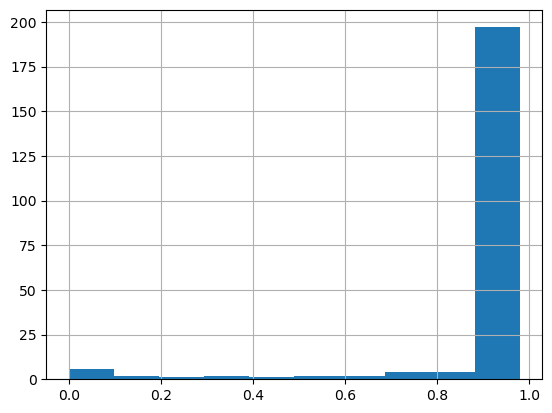

In [26]:
pd.DataFrame({
    "y_scores": list(y_scores), 
    "y_true": list(y_true)
}).query('y_true == 1')['y_scores'].hist()

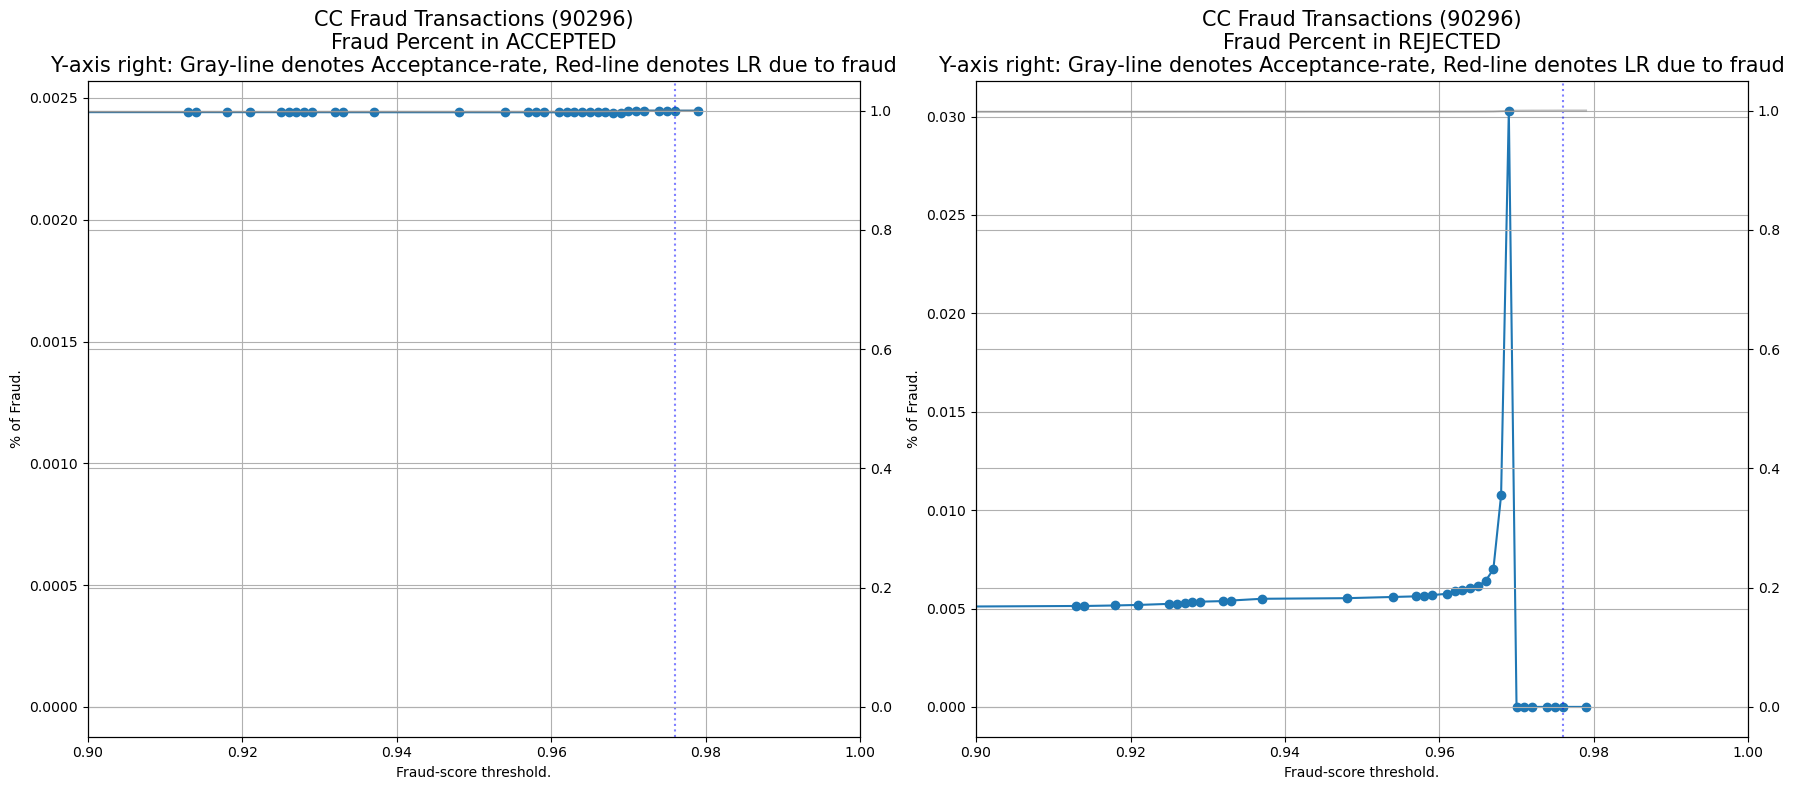

In [27]:
fig, ax = threshold_table_module.plot(
    cut_table=threshold_table_regular,
    accept_th=None, 
    reject_th=None, 
    title='CC Fraud Transactions')

ax[0].set_xlim(0.9, 1);
ax[1].set_xlim(0.9, 1);

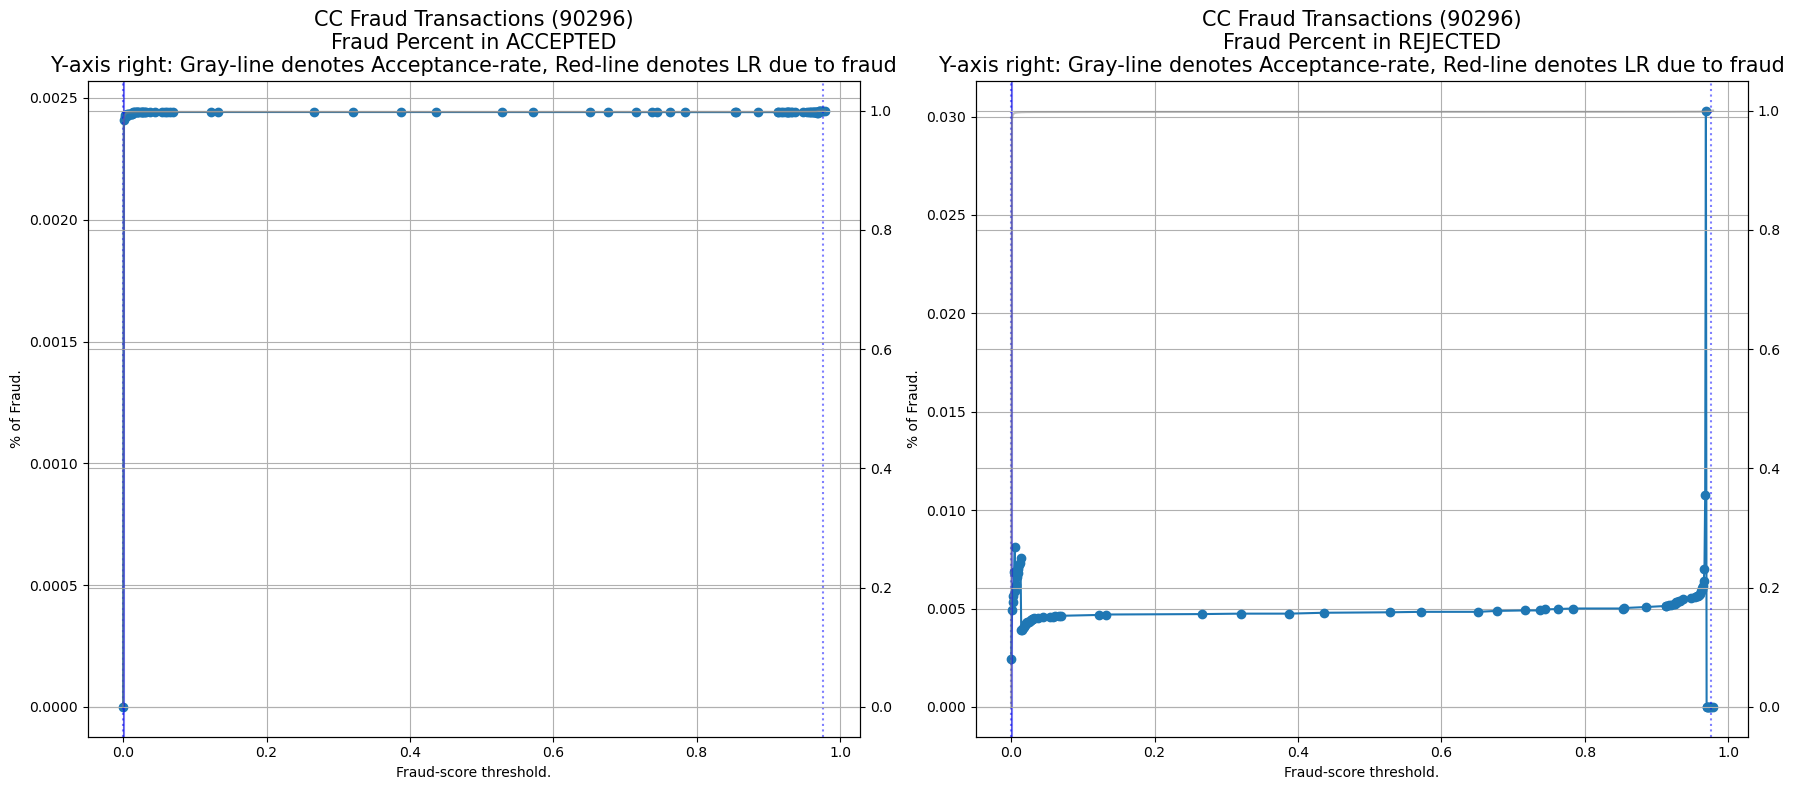

In [15]:
fig, ax = threshold_table_module.plot(
    cut_table=threshold_table_regular,
    accept_th=None, 
    reject_th=None, 
    title='CC Fraud Transactions')